# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import util
import os

In [2]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2024, 11, 7, 16, 39, 13, 131739)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
try:
    with open('./data/hopsworks-api-key.txt', 'r') as file:
        os.environ["HOPSWORKS_API_KEY"] = file.read().rstrip()
except:
    print("In production mode")

project = hopsworks.login()
fs = project.get_feature_store() 

secrets = util.secrets_api(project.name)
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1159321
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


## <span style="color:#ff5f27;"> ⚙️ Feature View Retrieval</span>


In [4]:
feature_view = fs.get_feature_view(
    name='air_quality_fv',
    version=1,
)

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='4.2043003E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.76s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2024-11-16 00:00:00+00:00,5.40,0.0,3.075841,159.443878,rotterdam-zuid
1,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid
2,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid
3,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid
4,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid
5,2024-11-15 00:00:00+00:00,4.00,0.0,8.311245,72.349792,rotterdam-zuid
6,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid
7,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid
8,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid


In [8]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
aq_3_latest = air_quality_fg.read().sort_values(by='date', ascending=False).head(3)

# Merge the latest air quality data with the batch data
batch_data = pd.concat([batch_data, aq_3_latest], ignore_index=False).sort_values(by='date')
batch_data = batch_data.reset_index(drop=True)
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.24s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,country,street,url
0,2024-11-05 00:00:00+00:00,NaN,NaN,NaN,NaN,rotterdam-zuid,69.0,60.0,51.0,34.0,netherland,zwartewaalstraat,https://api.waqi.info/feed/@5284
1,2024-11-06 00:00:00+00:00,NaN,NaN,NaN,NaN,rotterdam-zuid,69.0,69.0,60.0,51.0,netherland,zwartewaalstraat,https://api.waqi.info/feed/@5284
2,2024-11-07 00:00:00+00:00,NaN,NaN,NaN,NaN,rotterdam-zuid,55.0,69.0,69.0,60.0,netherland,zwartewaalstraat,https://api.waqi.info/feed/@5284
3,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
batch_data.at[3, 'pm25_1_day_before'] = aq_3_latest.iloc[0]['pm25']
batch_data.at[4, 'pm25_2_day_before'] = aq_3_latest.iloc[0]['pm25']
batch_data.at[5, 'pm25_3_day_before'] = aq_3_latest.iloc[0]['pm25']

batch_data.at[3, 'pm25_2_day_before'] = aq_3_latest.iloc[1]['pm25']
batch_data.at[4, 'pm25_3_day_before'] = aq_3_latest.iloc[1]['pm25']

batch_data.at[3, 'pm25_3_day_before'] = aq_3_latest.iloc[2]['pm25']

batch_data.drop(columns=['pm25', 'street', 'country', 'url'], inplace=True)
batch_data.drop(index=[0, 1, 2], inplace=True)
batch_data = batch_data.reset_index(drop=True)
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before
0,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid,55.0,69.0,69.0
1,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid,NaN,55.0,69.0
2,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid,NaN,NaN,55.0
3,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid,NaN,NaN,NaN
4,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid,NaN,NaN,NaN
5,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid,NaN,NaN,NaN
6,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid,NaN,NaN,NaN
7,2024-11-15 00:00:00+00:00,4.00,0.0,8.311245,72.349792,rotterdam-zuid,NaN,NaN,NaN
8,2024-11-16 00:00:00+00:00,5.40,0.0,3.075841,159.443878,rotterdam-zuid,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [10]:
for i in range(0, len(batch_data)):
    batch_data.at[i, 'predicted_pm25'] = retrieved_xgboost_model.predict(
        batch_data.loc[i, ['pm25_1_day_before', 'pm25_2_day_before', 'pm25_3_day_before', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].values.reshape(1, -1))[0]
    
    if i < len(batch_data) - 1: batch_data.at[i+1, 'pm25_1_day_before'] = batch_data.at[i, 'predicted_pm25']
    if i < len(batch_data) - 2: batch_data.at[i+2, 'pm25_2_day_before'] = batch_data.at[i, 'predicted_pm25']
    if i < len(batch_data) - 3: batch_data.at[i+3, 'pm25_3_day_before'] = batch_data.at[i, 'predicted_pm25']

batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,predicted_pm25
0,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid,55.000000,69.000000,69.000000,81.827682
1,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid,81.827682,55.000000,69.000000,99.479538
2,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid,99.479538,81.827682,55.000000,100.444916
3,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid,100.444916,99.479538,81.827682,59.533821
4,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid,59.533821,100.444916,99.479538,48.345551
5,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid,48.345551,59.533821,100.444916,54.745747
6,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid,54.745747,48.345551,59.533821,56.529819
7,2024-11-15 00:00:00+00:00,4.00,0.0,8.311245,72.349792,rotterdam-zuid,56.529819,54.745747,48.345551,81.650208
8,2024-11-16 00:00:00+00:00,5.40,0.0,3.075841,159.443878,rotterdam-zuid,81.650208,56.529819,54.745747,109.427422


In [11]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1_day_before            9 non-null      float32            
 7   pm25_2_day_before            9 non-null      float32            
 8   pm25_3_day_before            9 non-null      float32            
 9   predicted_pm25               9 non-null      float64            
dtypes: datetime64[us, UTC](1), float32(7), float64(1), obj

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [12]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
# Convert to float32 to be compatible with the feature store
batch_data['predicted_pm25'] = batch_data['predicted_pm25'].astype('float32')
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid,55.000000,69.000000,69.000000,81.827682,zwartewaalstraat,netherland,1
1,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid,81.827682,55.000000,69.000000,99.479538,zwartewaalstraat,netherland,2
2,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid,99.479538,81.827682,55.000000,100.444916,zwartewaalstraat,netherland,3
3,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid,100.444916,99.479538,81.827682,59.533821,zwartewaalstraat,netherland,4
4,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid,59.533821,100.444916,99.479538,48.345551,zwartewaalstraat,netherland,5
5,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid,48.345551,59.533821,100.444916,54.745747,zwartewaalstraat,netherland,6
6,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid,54.745747,48.345551,59.533821,56.529819,zwartewaalstraat,netherland,7
7,2024-11-15 00:00:00+00:00,4.00,0.0,8.311245,72.349792,rotterdam-zuid,56.529819,54.745747,48.345551,81.650208,zwartewaalstraat,netherland,8
8,2024-11-16 00:00:00+00:00,5.40,0.0,3.075841,159.443878,rotterdam-zuid,81.650208,56.529819,54.745747,109.427422,zwartewaalstraat,netherland,9


In [13]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype              
---  ------                       --------------  -----              
 0   date                         9 non-null      datetime64[us, UTC]
 1   temperature_2m_mean          9 non-null      float32            
 2   precipitation_sum            9 non-null      float32            
 3   wind_speed_10m_max           9 non-null      float32            
 4   wind_direction_10m_dominant  9 non-null      float32            
 5   city                         9 non-null      object             
 6   pm25_1_day_before            9 non-null      float32            
 7   pm25_2_day_before            9 non-null      float32            
 8   pm25_3_day_before            9 non-null      float32            
 9   predicted_pm25               9 non-null      float32            
 10  street                       9 non-null      object   

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

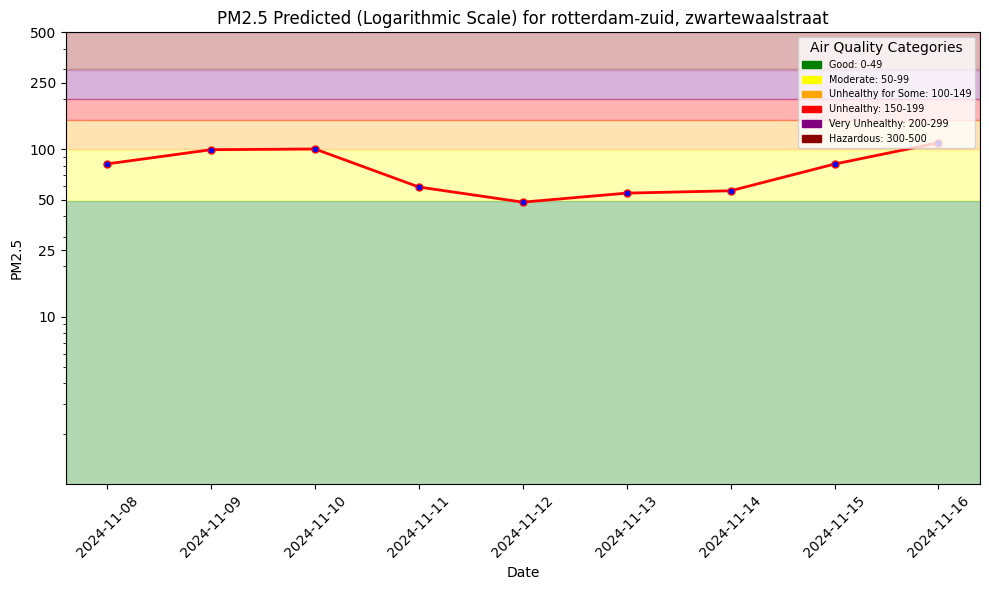

In [14]:
file_path = "./docs/air_quality_model/assets/images/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, file_path)
plt.show()

In [15]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=1,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [16]:
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.130020,rotterdam-zuid,55.000000,69.000000,69.000000,81.827682,zwartewaalstraat,netherland,1
1,2024-11-09 00:00:00+00:00,10.25,0.0,6.120000,180.000000,rotterdam-zuid,81.827682,55.000000,69.000000,99.479538,zwartewaalstraat,netherland,2
2,2024-11-10 00:00:00+00:00,11.90,0.0,11.885453,215.134277,rotterdam-zuid,99.479538,81.827682,55.000000,100.444916,zwartewaalstraat,netherland,3
3,2024-11-11 00:00:00+00:00,12.40,0.0,23.675303,314.384033,rotterdam-zuid,100.444916,99.479538,81.827682,59.533821,zwartewaalstraat,netherland,4
4,2024-11-12 00:00:00+00:00,9.10,0.5,15.307410,311.185822,rotterdam-zuid,59.533821,100.444916,99.479538,48.345551,zwartewaalstraat,netherland,5
5,2024-11-13 00:00:00+00:00,7.80,0.0,16.595179,86.268677,rotterdam-zuid,48.345551,59.533821,100.444916,54.745747,zwartewaalstraat,netherland,6
6,2024-11-14 00:00:00+00:00,4.20,0.0,17.651016,78.231735,rotterdam-zuid,54.745747,48.345551,59.533821,56.529819,zwartewaalstraat,netherland,7
7,2024-11-15 00:00:00+00:00,4.00,0.0,8.311245,72.349792,rotterdam-zuid,56.529819,54.745747,48.345551,81.650208,zwartewaalstraat,netherland,8
8,2024-11-16 00:00:00+00:00,5.40,0.0,3.075841,159.443878,rotterdam-zuid,81.650208,56.529819,54.745747,109.427422,zwartewaalstraat,netherland,9


In [17]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |          | Rows 0/9 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159321/jobs/named/aq_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x28499aa10>, None)

In [18]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.66s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,predicted_pm25,street,country,days_before_forecast_day
0,2024-11-08 00:00:00+00:00,8.25,0.0,15.273505,98.13002,rotterdam-zuid,55.0,69.0,69.0,81.827682,zwartewaalstraat,netherland,1


In [19]:
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.32s) 


,date,pm25,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,country,city,street,url
0,2023-02-15 00:00:00+00:00,139.0,107.0,78.0,56.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
1,2019-12-21 00:00:00+00:00,19.0,18.0,41.0,36.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
2,2018-03-17 00:00:00+00:00,34.0,74.0,55.0,43.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
3,2022-05-26 00:00:00+00:00,32.0,27.0,24.0,60.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
4,2015-03-31 00:00:00+00:00,27.0,28.0,43.0,50.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
...,...,...,...,...,...,...,...,...,...
3347,2019-01-22 00:00:00+00:00,108.0,100.0,65.0,75.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
3348,2019-01-13 00:00:00+00:00,31.0,28.0,23.0,29.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
3349,2015-08-02 00:00:00+00:00,57.0,45.0,25.0,20.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284
3350,2016-12-22 00:00:00+00:00,66.0,73.0,80.0,96.0,netherland,rotterdam-zuid,zwartewaalstraat,https://api.waqi.info/feed/@5284


In [20]:
from functions.util import backfill_predictions_for_monitoring

outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'], ascending=False)

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model, today)
hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.82s) 


Uploading Dataframe: 0.00% |          | Rows 0/10 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: aq_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/1159321/jobs/named/aq_predictions_1_offline_fg_materialization/executions


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_1_day_before,pm25_2_day_before,pm25_3_day_before,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2024-10-28 00:00:00+00:00,12.392249,1.4,26.317575,217.800476,rotterdam-zuid,30.0,47.0,46.0,25.619850,36.0,zwartewaalstraat,netherland,1
1,2024-10-29 00:00:00+00:00,13.306832,0.0,17.570988,221.514709,rotterdam-zuid,36.0,30.0,47.0,44.073063,34.0,zwartewaalstraat,netherland,1
2,2024-10-30 00:00:00+00:00,12.854749,0.0,6.698806,330.043701,rotterdam-zuid,34.0,36.0,30.0,45.509991,21.0,zwartewaalstraat,netherland,1
3,2024-10-31 00:00:00+00:00,10.421417,0.0,8.557102,228.845139,rotterdam-zuid,21.0,34.0,36.0,41.538216,52.0,zwartewaalstraat,netherland,1
4,2024-11-01 00:00:00+00:00,10.840167,0.0,16.341383,231.500885,rotterdam-zuid,52.0,21.0,34.0,56.147190,62.0,zwartewaalstraat,netherland,1
5,2024-11-02 00:00:00+00:00,11.427667,0.0,14.230248,65.508621,rotterdam-zuid,62.0,52.0,21.0,61.467205,34.0,zwartewaalstraat,netherland,1
6,2024-11-03 00:00:00+00:00,7.763084,0.0,8.788720,86.886353,rotterdam-zuid,34.0,62.0,52.0,67.414742,51.0,zwartewaalstraat,netherland,1
7,2024-11-04 00:00:00+00:00,7.906834,0.0,13.804955,101.284599,rotterdam-zuid,51.0,34.0,62.0,66.689468,60.0,zwartewaalstraat,netherland,1
8,2024-11-05 00:00:00+00:00,7.277667,0.0,8.694204,167.150574,rotterdam-zuid,60.0,51.0,34.0,81.559776,69.0,zwartewaalstraat,netherland,1
9,2024-11-07 00:00:00+00:00,8.100000,0.0,12.979984,109.440125,rotterdam-zuid,69.0,69.0,60.0,72.131897,55.0,zwartewaalstraat,netherland,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

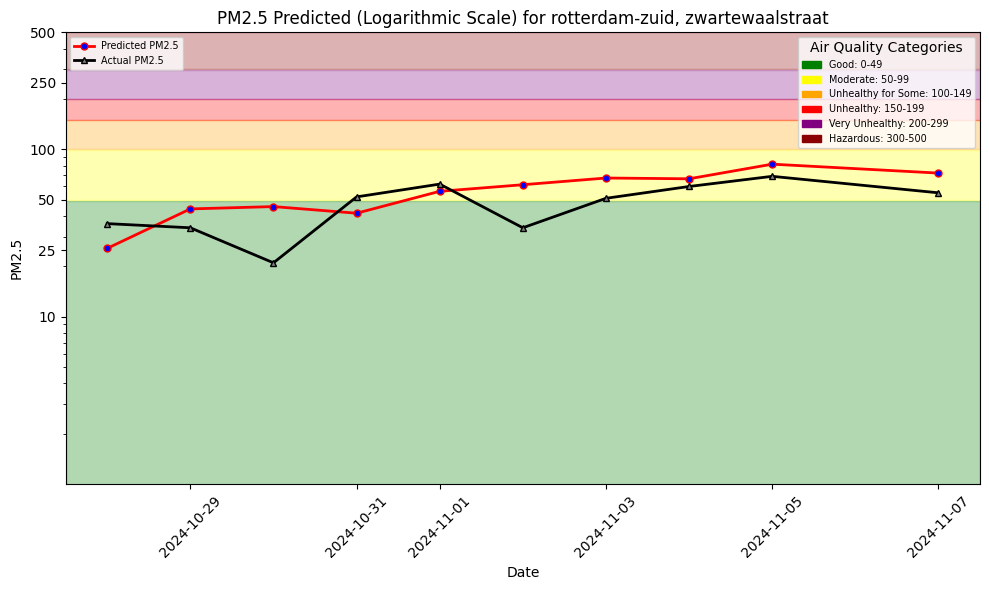

In [21]:
file_path = "./docs/air_quality_model/assets/images/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, file_path, hindcast=True)
plt.show()

---